<a href="https://colab.research.google.com/github/Ravi-kjain84/Articles/blob/main/22_Using_machine_learning_for_detecting_liquidity_risk_in_banks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Necessary Libraries

First few rows of the dataset:
   Bank ID    Date Period Country  Liquid Assets to Deposit  \
0  4343019  FY2016  2016Y     TZA                      0.14   
1  4853821  FY2019  2019Y     TZA                      0.14   
2  4343019  FY2014  2014Y     TZA                      0.16   
3  6200009  FY2019  2019Y     TZA                      0.17   
4  6200009  FY2021  2021Y     TZA                      0.18   

   Credit in Central Bank to Total Deposits  Net Loans to Total Assets  \
0                                      0.13                      64.17   
1                                      0.03                      49.10   
2                                      0.13                      51.32   
3                                      0.08                      73.62   
4                                      0.07                      69.70   

   Net Loans and Leases to Deposits     Bank Size  Inflation Rate  GDP Growth  \
0                             99.33  5.341975e+07            5.1

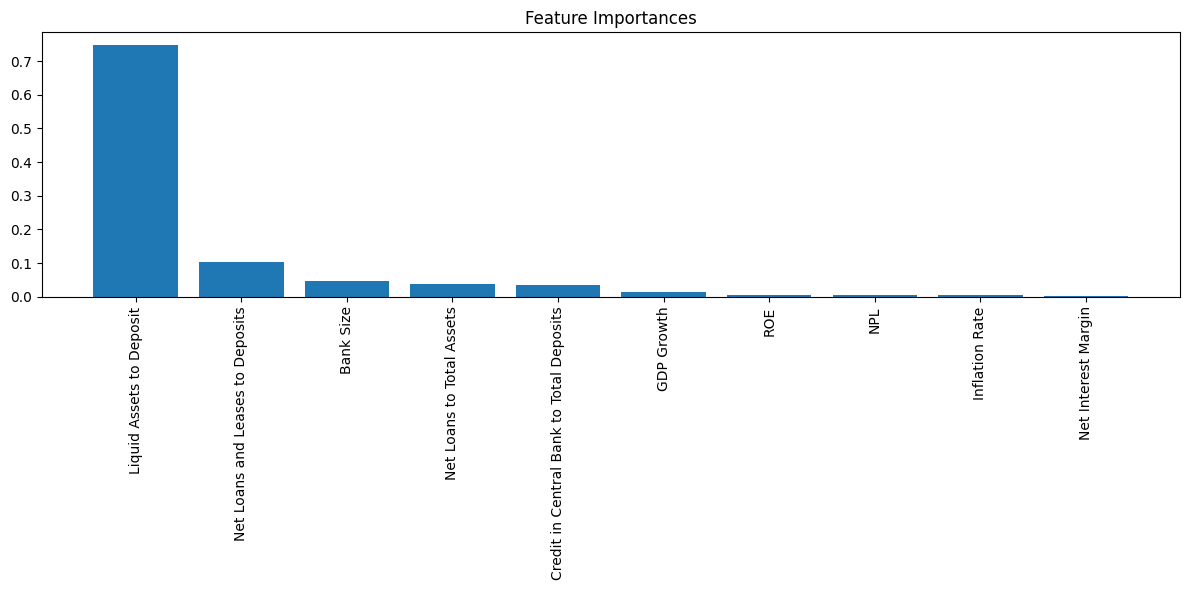

Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 65363740.0000 - mean_absolute_error: 65363740.0000
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 12389376.0000 - mean_absolute_error: 12389376.0000
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 4870739.5000 - mean_absolute_error: 4870739.5000
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 3484891.0000 - mean_absolute_error: 3484891.0000
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 6625035.5000 - mean_absolute_error: 6625035.5000
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 5475272.5000 - mean_absolute_error: 5475272.5000
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 4133842.7500 - mean_absolute_error: 4133842.7500
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 2289406.0000 - mean_absolute_error: 2289406.0000
Epoch 9/100
16/16 [=

In [17]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 2: Load the Dataset
data = pd.read_csv('liquidity_data_template.csv')  # Ensure the file is in the same directory or provide the correct path

# Step 3: Display the first few rows of the dataframe
print("First few rows of the dataset:")
print(data.head())

# Inspect the columns in the dataset
print("\nColumns in the dataset:")
print(data.columns)

# Step 4: Data Preprocessing
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



# Step 5: Feature Selection
features = [
    'Liquid Assets to Deposit',
    'Credit in Central Bank to Total Deposits', 'Net Loans to Total Assets',
    'Net Loans and Leases to Deposits', 'Bank Size', 'Inflation Rate',
    'GDP Growth', 'NPL', 'Net Interest Margin', 'ROE'
]
target = 'MLA'  # Use the correct target column name here

# Step 6: Split the Data into Training and Testing Sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Step 7: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Step 8: Evaluate the Random Forest Model
print("\nRandom Forest Model Mean Squared Error:", mean_squared_error(y_test, rf_predictions))
print("\nRandom Forest Model R^2 Score:", r2_score(y_test, rf_predictions))

# Step 9: Visualize the Results
# Feature Importance
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


# Step 10: Neural Network for Regression
mlp_model = Sequential()
mlp_model.add(Dense(64, input_dim=len(features), activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(1))  # No activation for the output layer in regression

mlp_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the MLP model
mlp_model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the MLP model
mlp_mae, mlp_mae_metric = mlp_model.evaluate(X_test, y_test)
mlp_predictions = mlp_model.predict(X_test)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
mlp_r2 = r2_score(y_test, mlp_predictions)

print("\nMLP Model Mean Absolute Error:", mlp_mae)
print("\nMLP Model Root Mean Squared Error:", mlp_rmse)
print("\nMLP Model R^2 Score:", mlp_r2)

# Step 11: Results Discussion
# Add your observations, insights, and any further analysis here
